<a href="https://colab.research.google.com/github/nicorunini/CCMACLRL_EXERCISES_COM232/blob/main/midtermexam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

In [4]:
train_url = 'https://github.com/robitussin/CCMACLRL_EXAM/blob/ebd51da1dafde093c18d9e8f35c834d91b2887f7/datasets/train.csv?raw=true'
test_url = 'https://github.com/robitussin/CCMACLRL_EXAM/blob/ebd51da1dafde093c18d9e8f35c834d91b2887f7/datasets/test.csv?raw=true'
sample_submission_url = 'https://github.com/robitussin/CCMACLRL_EXAM/blob/ebd51da1dafde093c18d9e8f35c834d91b2887f7/datasets/sample_submission.csv?raw=true'

train = pd.read_csv(train_url)
test = pd.read_csv(test_url)
sample_submission = pd.read_csv(sample_submission_url)

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Sample submission shape:", sample_submission.shape)


Train shape: (1117957, 22)
Test shape: (745305, 21)
Sample submission shape: (745305, 2)


In [5]:
TARGET = "FloodProbability"
ID_COL = "id"


X = train.drop(columns=[ID_COL, TARGET])
y = train[TARGET]
X_test = test.drop(columns=[ID_COL])


# Ensure numeric only
X = X.apply(pd.to_numeric, errors='coerce').fillna(X.median())
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(X.median())


# Train/Validation split for holdout evaluation
X_train, X_valid, y_train, y_valid = train_test_split(
X, y, test_size=0.2, random_state=42
)

In [6]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [7]:
pred_valid = linreg.predict(X_valid)
pred_valid_clipped = np.clip(pred_valid, 0, 1)


R2 = r2_score(y_valid, pred_valid_clipped)
RMSE = math.sqrt(mean_squared_error(y_valid, pred_valid_clipped))
n, p = X_valid.shape
adj_R2 = 1 - (1 - R2) * (n - 1) / (n - p - 1)


print("\n=== Holdout Metrics ===")
print(f"R^2: {R2:.4f}")
print(f"Adj. R^2: {adj_R2:.4f}")
print(f"RMSE: {RMSE:.4f}")


=== Holdout Metrics ===
R^2: 0.8449
Adj. R^2: 0.8449
RMSE: 0.0201


In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(LinearRegression(), X, y, cv=kf, scoring='r2')
print("\n=== 5-Fold CV (R^2) ===")
print("Scores:", np.round(cv_scores, 4))
print("Mean R^2:", np.round(cv_scores.mean(), 4), "| Std:", np.round(cv_scores.std(), 4))


=== 5-Fold CV (R^2) ===
Scores: [0.8449 0.845  0.845  0.8449 0.845 ]
Mean R^2: 0.8449 | Std: 0.0001


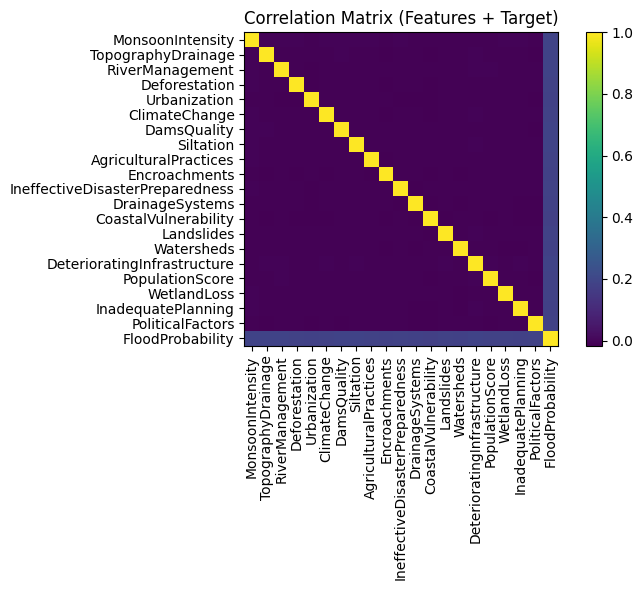

In [9]:
plt.figure(figsize=(8, 6))
corr = train.drop(columns=[ID_COL]).corr()
plt.imshow(corr, interpolation='nearest')
plt.title('Correlation Matrix (Features + Target)')
plt.colorbar()
plt.xticks(ticks=np.arange(len(corr.columns)), labels=corr.columns, rotation=90)
plt.yticks(ticks=np.arange(len(corr.columns)), labels=corr.columns)
plt.tight_layout()
plt.show()

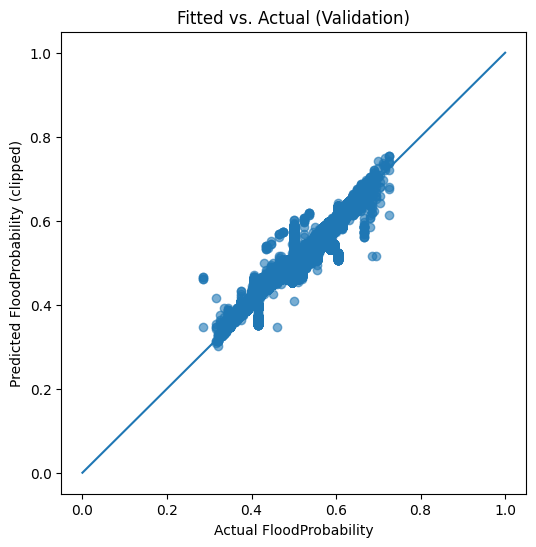

In [10]:
plt.figure(figsize=(6, 6))
plt.scatter(y_valid, pred_valid_clipped, alpha=0.6)
plt.plot([0, 1], [0, 1])
plt.xlabel('Actual FloodProbability')
plt.ylabel('Predicted FloodProbability (clipped)')
plt.title('Fitted vs. Actual (Validation)')
plt.show()

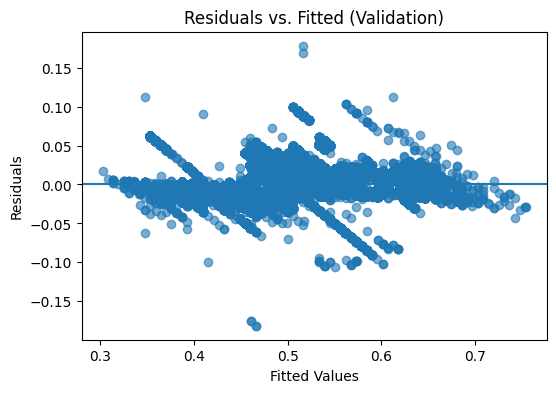

In [11]:
residuals = y_valid - pred_valid_clipped
plt.figure(figsize=(6, 4))
plt.scatter(pred_valid_clipped, residuals, alpha=0.6)
plt.axhline(0)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted (Validation)')
plt.show()

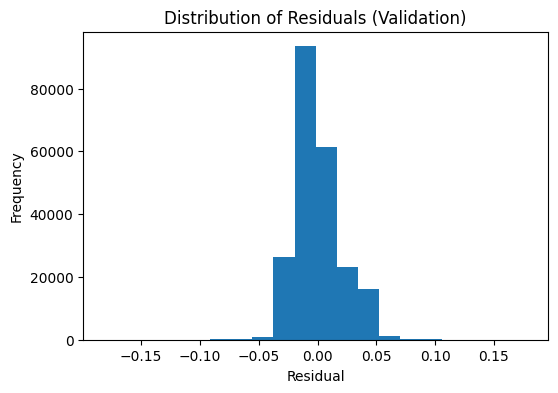

In [12]:
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=20)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Validation)')
plt.show()

In [13]:
def compute_vif(X_df: pd.DataFrame) -> pd.DataFrame:
  cols = X_df.columns.tolist()
  vif_list = []
  for col in cols:
    X_other = X_df.drop(columns=[col])
    y_col = X_df[col]
    lr = LinearRegression()
    lr.fit(X_other, y_col)
    y_pred = lr.predict(X_other)
    r2_j = r2_score(y_col, y_pred)
    vif = np.inf if r2_j >= 1.0 else 1.0 / (1.0 - r2_j)
    vif_list.append((col, vif))
  return pd.DataFrame(vif_list, columns=["feature", "VIF"]).sort_values("VIF", ascending=False)


vif_table = compute_vif(X)
print("\n=== VIF (All Features) ===")
print(vif_table)


=== VIF (All Features) ===
                            feature       VIF
12             CoastalVulnerability  1.003687
9                     Encroachments  1.003349
4                      Urbanization  1.003128
11                  DrainageSystems  1.003057
19                 PoliticalFactors  1.003004
14                       Watersheds  1.002943
18               InadequatePlanning  1.002866
10  IneffectiveDisasterPreparedness  1.002712
16                  PopulationScore  1.002549
17                      WetlandLoss  1.002540
8             AgriculturalPractices  1.002531
3                     Deforestation  1.002477
13                       Landslides  1.002476
1                TopographyDrainage  1.002464
5                     ClimateChange  1.002400
2                   RiverManagement  1.002344
6                       DamsQuality  1.002310
7                         Siltation  1.002158
15      DeterioratingInfrastructure  1.001758
0                  MonsoonIntensity  1.001718


In [14]:
linreg_full = LinearRegression()
linreg_full.fit(X, y)


pred_test = linreg_full.predict(X_test)
pred_test = np.clip(pred_test, 0, 1)


submission = sample_submission.copy()
submission[TARGET] = pred_test


submission.to_csv("submission_final.csv", index=False)
print("\nSaved submission to submission_final.csv")


Saved submission to submission_final.csv
